In [1]:
from pathlib import Path
import datetime
import pandas as pd
import numpy as np
import xarray as xr
import dask
import dask.bag as db

# # Debug for single process
# import dask
# dask.config.set(scheduler='synchronous')

In [3]:
# Setup Path
p_dssat = Path('./data/DSSAT')
p_s1 = Path('./data/Sentinel-1')

# finding the time that both parameters are available (LAI is daily but AMP is not)
harvestdate=datetime.date(2017, 10, 1)

## Part1: Aligning data into an Xarray Dataset
Aligned dataset should have:

- Dimensions: space and time
- Coordinates: at least 1 for space and time, each
- Data vars: 1) Input, 2) Output, 3) Split classifier: split the dataset into different training processes.

Act points: 
    1. example notebooks for aligning, from various sources.
    2. Zarr storage of the original data
    3. Consider how to handle the missing data since this is not tolerated by the training

In [4]:
input_list = ['LAI', 'SWTD', 'SWTD6', 'CWAD']
output_list = ['CR']

# Load inputs
df_list = []
for key in input_list:
    df = pd.read_pickle(p_dssat/"brabant_{}.pkl".format(key))
    df.index = df.index.date
    df_list.append(df)

Brabant_LAI, Brabant_SWTD, Brabant_SWTD6, Brabant_CWAD = df_list

# Load outputs
df_list = []
for key in output_list:
    df = pd.read_pickle(p_s1/"Amp_{}_New.pkl".format(key))
    df_list.append(df)
Amp_CR_New = df_list[0]

In [5]:
# Align the temporal index (common dates)
idx_time = Brabant_LAI.index.intersection(Amp_CR_New.index)
idx_time = idx_time[idx_time<harvestdate]

# Allign the spactial index (common field IDs)
idx_space =  Brabant_LAI.columns.intersection(Amp_CR_New.columns)

print(idx_time)
print(idx_space)

Index([2017-05-07, 2017-05-13, 2017-05-19, 2017-05-25, 2017-05-31, 2017-06-06,
       2017-06-12, 2017-06-18, 2017-06-24, 2017-06-30, 2017-07-06, 2017-07-12,
       2017-07-18, 2017-07-24, 2017-07-30, 2017-08-05, 2017-08-11, 2017-08-17,
       2017-08-23, 2017-08-29, 2017-09-04, 2017-09-10, 2017-09-22, 2017-09-28],
      dtype='object')
Int64Index([1526157, 1526199, 1526200, 1526234, 1526249, 1526374, 1526375,
            1526429, 1526436, 1526442,
            ...
            1566562, 1566581, 1566582, 1566596, 1566602, 1566624, 1566663,
            1566881, 1566913, 1566965],
           dtype='int64', length=1283)


In [6]:
# Initiate an Xarray Dataset with coords
ds = xr.Dataset(coords={"space": idx_space, "time": idx_time})

# Assign input and outputs as data variables
df_list = [Brabant_LAI, Brabant_SWTD, Brabant_SWTD6, Brabant_CWAD, Amp_CR_New]
for k, v in zip(input_list + output_list, df_list):
    v_sel = v.loc[idx_time, idx_space]
    ds = ds.assign({k: (("time", "space"), v_sel.values)})
ds

<xarray.Dataset>
Dimensions:  (space: 1283, time: 24)
Coordinates:
  * space    (space) int64 1526157 1526199 1526200 ... 1566881 1566913 1566965
  * time     (time) object 2017-05-07 2017-05-13 ... 2017-09-22 2017-09-28
Data variables:
    LAI      (time, space) float64 0.0 0.0 0.0 0.0 0.0 ... 3.72 3.68 3.54 3.06
    SWTD     (time, space) float64 0.178 0.23 0.228 0.192 ... 0.274 0.23 0.217
    SWTD6    (time, space) float64 0.143 0.236 0.234 0.174 ... 0.112 0.197 0.175
    CWAD     (time, space) float64 0.0 0.0 0.0 0.0 ... 2.793 2.817 2.773 2.761
    CR       (time, space) float64 0.1164 0.1593 0.1532 ... 0.2877 0.2314 0.3094

## Part 2: data split

Act points:
1. Implement training split:
  - Two methods:
    1. Splitting into databags using a identifier. The identifier should be 1D. Elements fall into will be split into databags  The results will be a small number of uneven datasets.
    ```
      ds.mot.training_split({'crop_id': [222,321,555]})
    ``` 
    2. Chunk in space and/or time with a chunksize. The results will be one DS with constant number of chunks.
    ```
      ds.mot.training_split({axis: chunksize})
    ```
  - Split identifier/chunk in space or time. (Not at the same time)

2. Implement train test split
  - Replace Jackknife GPI with the splitted data
  - Shuffle in space and/or time

3. Increase the visibility of the splition

4. Export to X, Y to fit the old DNN implementation?

### Training split split: define in/output for each model, if multiple model exists

In [7]:
# POTENTIAL FUNCTION
# ds.mot.training_split({axis: identifier}) or ds.mot.training_split({axis: chunksize})
# return 1) Dask DataBag of DS (uneven chunks) or 2) DS with DA chunks (even chunks)

# Example : Split with identifier (ueven chunks)
# Add splitting identifier in both space and time dimension
np.random.seed(seed=1234)
flag_space = np.random.randint(low=1, high=4, size=(ds.dims['space'],))
flag_time = np.random.randint(low=1, high=3, size=(ds.dims['time'],))

ds = ds.assign({"flag_space":(("space", flag_space)), "flag_time":(("time", flag_time))})
list_ds = [] # This will be converted to a dask databag
for flag in np.unique(flag_space):
    list_ds.append(ds.sel(space=ds["flag_space"]==flag))
ds_bags = db.from_sequence(list_ds)
ds_bags

dask.bag<from_sequence, npartitions=3>

In [9]:
ds.chunk({"space":1})

<xarray.Dataset>
Dimensions:     (space: 1283, time: 24)
Coordinates:
  * space       (space) int64 1526157 1526199 1526200 ... 1566913 1566965
  * time        (time) object 2017-05-07 2017-05-13 ... 2017-09-22 2017-09-28
Data variables:
    LAI         (time, space) float64 dask.array<chunksize=(24, 1), meta=np.ndarray>
    SWTD        (time, space) float64 dask.array<chunksize=(24, 1), meta=np.ndarray>
    SWTD6       (time, space) float64 dask.array<chunksize=(24, 1), meta=np.ndarray>
    CWAD        (time, space) float64 dask.array<chunksize=(24, 1), meta=np.ndarray>
    CR          (time, space) float64 dask.array<chunksize=(24, 1), meta=np.ndarray>
    flag_space  (space) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    flag_time   (time) int64 dask.array<chunksize=(24,), meta=np.ndarray>

In [7]:
ds1 = ds_bags.take(1)

In [8]:
ds1

(<xarray.Dataset>
 Dimensions:     (space: 397, time: 24)
 Coordinates:
   * space       (space) int64 1526200 1526234 1526249 ... 1566421 1566596
   * time        (time) object 2017-05-07 2017-05-13 ... 2017-09-22 2017-09-28
 Data variables:
     LAI         (time, space) float64 0.0 0.0 0.0 0.0 ... 3.45 3.48 3.44 3.64
     SWTD        (time, space) float64 0.228 0.192 0.243 ... 0.197 0.225 0.186
     SWTD6       (time, space) float64 0.234 0.174 0.203 ... 0.116 0.099 0.096
     CWAD        (time, space) float64 0.0 0.0 0.0 0.0 ... 2.812 2.854 2.789
     CR          (time, space) float64 0.1532 0.1506 0.13 ... 0.3575 0.3042
     flag_space  (space) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
     flag_time   (time) int64 2 1 2 2 2 2 1 2 2 1 2 2 2 2 2 1 1 2 2 1 1 1 2 2,)

### Train-test split: split training and testing data 

In [8]:
# Functions to be mapped

def to_dataframe(ds):
    # return ds.to_dataframe()
    return ds.to_dask_dataframe()

def chunk(ds, chunks):
    return ds.chunk(chunks)

In [9]:
# Construct cluster
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default

In [10]:
import dask_ml.model_selection as dcv

test_size=0.33
f_shuffle=True

df_bags = ds_bags.map(chunk, {'space':100}).map(to_dataframe)
train_test_bags = df_bags.map(dcv.train_test_split, test_size=test_size, shuffle=f_shuffle, random_state=1) # train_test_split only takes da, df or series. No ds.

In [13]:
df_bags.take(1)

(Dask DataFrame Structure:
                space    time      LAI     SWTD    SWTD6     CWAD       CR flag_space flag_time
 npartitions=4                                                                                 
 0              int64  string  float64  float64  float64  float64  float64      int64     int64
 2400             ...     ...      ...      ...      ...      ...      ...        ...       ...
 4800             ...     ...      ...      ...      ...      ...      ...        ...       ...
 7200             ...     ...      ...      ...      ...      ...      ...        ...       ...
 9527             ...     ...      ...      ...      ...      ...      ...        ...       ...
 Dask Name: concat-indexed, 1 graph layer,)

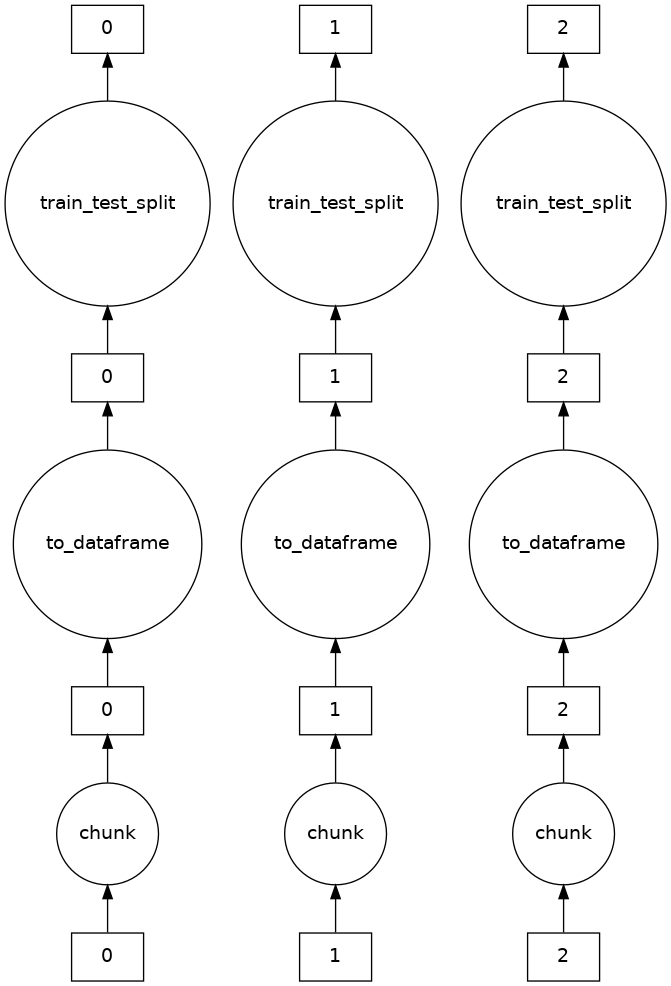

In [13]:
train_test_bags.visualize()

In [14]:
train_test = train_test_bags.take(1)

In [15]:
train_test[0][1].compute()

,space,time,LAI,SWTD,SWTD6,CWAD,CR,flag_space,flag_time
903,1530044,2017-08-05,4.31,0.307,0.119,1.3075,0.250788,1,1
447,1527915,2017-08-05,4.42,0.320,0.081,1.3301,0.403791,1,1
62,1526249,2017-07-30,4.56,0.329,0.140,1.1199,0.366130,1,2
1307,1531514,2017-07-12,4.24,0.361,0.101,0.5987,0.266913,1,2
72,1526505,2017-05-07,0.00,0.198,0.182,0.0000,0.102014,1,2
...,...,...,...,...,...,...,...,...,...
9458,1566240,2017-05-19,0.00,0.211,0.135,0.0000,0.098393,1,2
8538,1562313,2017-08-23,3.99,0.195,0.100,1.9152,0.264557,1,2
7679,1558019,2017-09-28,3.44,0.214,0.094,2.9235,0.303523,1,2
8941,1564609,2017-07-24,4.60,0.380,0.119,0.9152,0.413257,1,2


In [13]:
# res_train_test_bags = train_test_bags.compute()
# res_train_test_bags

### Part 3: Search for the optimal parameter

- Action point:
    1. What format use to save the trained

    2. Categorize teh results
        - Link model with training data
        - Metadata to add
    

In [16]:
# Setup grid search
# use the estimator definition and pipeline objects in sklearn 
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.model_selection import RepeatedKFold

from dask_ml.preprocessing import MinMaxScaler
from dask_ml.model_selection import GridSearchCV

regSVR = make_pipeline(MinMaxScaler(), SVR())
kernel = ["poly","rbf","sigmoid"]
# C = [100,10,1,0.1]
C = [1,0.1]
gamma = ["scale"]
grid = dict(svr__kernel=kernel, svr__C=C, svr__gamma=gamma)
cv = RepeatedKFold(n_splits=4,n_repeats=2,random_state=1)
grid_search = GridSearchCV(estimator=regSVR, param_grid=grid, cv=cv, scoring=["r2","neg_mean_squared_error"], refit="r2")

In [17]:
def sel_trainning(train_test):
    return train_test.__getitem__(0)

In [18]:
def search(df, grid_search, input_list, output_list):
    grid_result = grid_search.fit(df[input_list], df[output_list])
    return grid_result

In [19]:
optimazed_estimators = train_test_bags.map(sel_trainning).map(search, grid_search=grid_search, input_list=input_list, output_list=output_list)

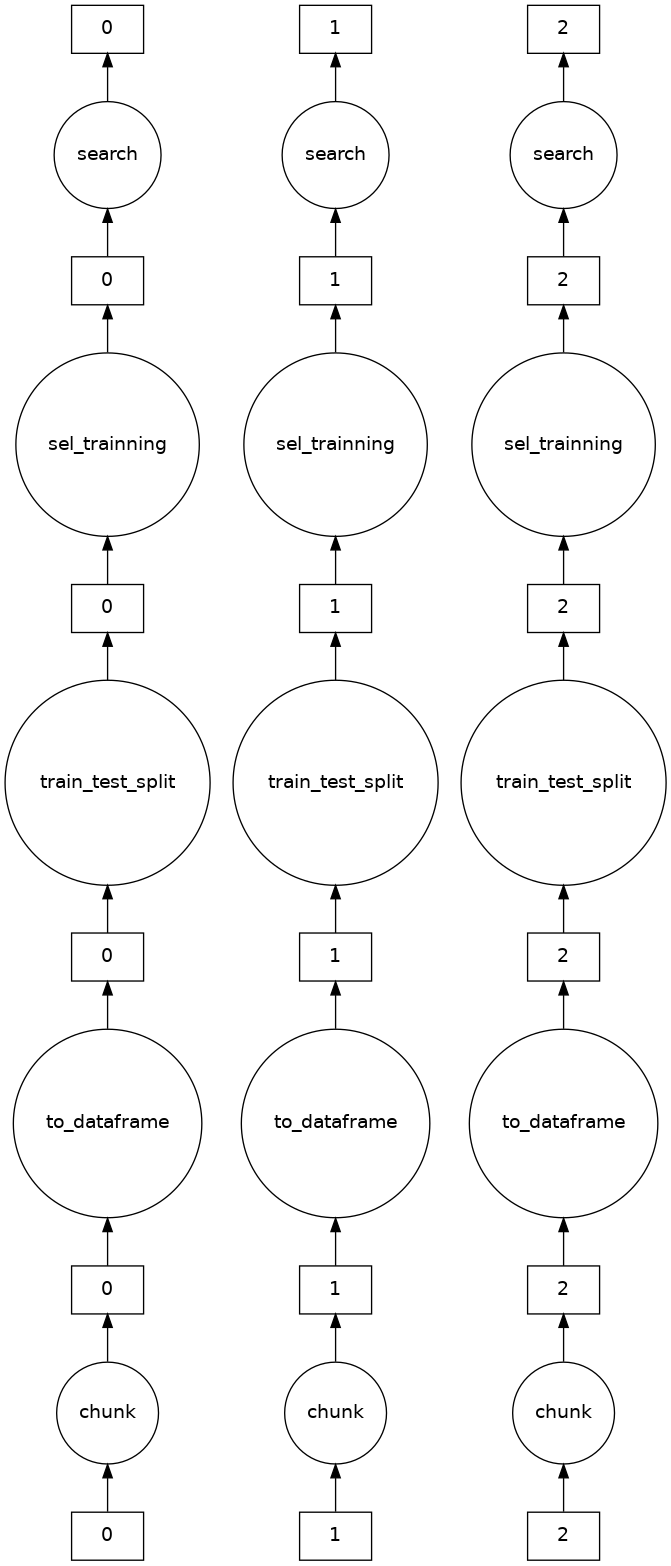

In [20]:
optimazed_estimators.visualize()

In [21]:
optimazed_estimators_realized = optimazed_estimators.compute()

/home/oku/miniconda3/envs/motrainer-gen/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/oku/miniconda3/envs/motrainer-gen/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/oku/miniconda3/envs/motrainer-gen/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/oku/miniconda3/envs/motrainer-gen/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning

In [28]:
len(optimazed_estimators_realized)

3

In [29]:
# Potential function export model to: 1)pickl; 2)skop; 3)onmx; Attach with metadata.
import pickle

for model, id in zip(optimazed_estimators_realized, range(len(optimazed_estimators_realized))):
    name_model = f"model{id}.pickle"
    with open(name_model, "wb") as f:
        pickle.dump(model, f)

### Part 4: Testing

Action points:

    1. Nest this under hyper parameter searching?

In [30]:
# Load the models back
list_model = []
for id in range(3): 
    with open(f"model{id}.pickle", "rb") as f:
        list_model.append(pickle.load(f))
list_model

[GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=4, random_state=1),
              estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                        ('svr', SVR())]),
              param_grid={'svr__C': [1, 0.1], 'svr__gamma': ['scale'],
                          'svr__kernel': ['poly', 'rbf', 'sigmoid']},
              refit='r2', scoring=['r2', 'neg_mean_squared_error']),
 GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=4, random_state=1),
              estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                        ('svr', SVR())]),
              param_grid={'svr__C': [1, 0.1], 'svr__gamma': ['scale'],
                          'svr__kernel': ['poly', 'rbf', 'sigmoid']},
              refit='r2', scoring=['r2', 'neg_mean_squared_error']),
 GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=4, random_state=1),
              estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                       

In [31]:
def sel_testing(train_test):
    return train_test.__getitem__(1)

In [32]:
list_test_data = train_test_bags.map(sel_testing).compute()

In [33]:
from sklearn.metrics import mean_squared_error , r2_score,  mean_absolute_error

# Potential function: parallelization for testing?
list_metrics = []
for model, test_data in zip(list_model, list_test_data):
    X_test = test_data[input_list]
    Y_test = test_data[output_list]
    Y_eval = model.predict(X_test)

    metrics = {"MSE_SVR": mean_squared_error(Y_test,Y_eval),
               "MAE_SVR": mean_absolute_error(Y_test,Y_eval),
               "R_2":r2_score(Y_test,Y_eval)}
    list_metrics.append(metrics)

In [36]:
list_metrics

[{'MSE_SVR': 0.004296982107806475,
  'MAE_SVR': 0.04966652693673627,
  'R_2': 0.4397767688365809},
 {'MSE_SVR': 0.005072161978729764,
  'MAE_SVR': 0.05289525383554692,
  'R_2': 0.40140242545362304},
 {'MSE_SVR': 0.004226520566363599,
  'MAE_SVR': 0.050885645540441504,
  'R_2': 0.45824804036964306}]